In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import haversine
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, GlobalAveragePooling1D, Reshape, multiply, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from haversine import haversine
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
# Load data
data = pd.read_csv('Raw Dataset/train_data.csv')

data['BaseDateTime'] = pd.to_datetime(data['BaseDateTime'])
data.sort_values('BaseDateTime', inplace=True)

print(data.head())

       Unnamed: 0.1  Unnamed: 0       MMSI        BaseDateTime       LAT  \
0           1319408     4953877  247320400 2023-12-01 17:09:51  22.55168   
3422        1319408     4953877  247320400 2023-12-01 17:09:51  22.55168   
5019        1319408     4953877  247320400 2023-12-01 17:09:51  22.55168   
7525        1319408     4953877  247320400 2023-12-01 17:09:51  22.55168   
10762       1319408     4953877  247320400 2023-12-01 17:09:51  22.55168   

            LON   SOG   COG  Heading      VesselName         IMO CallSign  \
0     -97.32398  21.8  83.6     84.0  EUROCARGO BARI  IMO9471082     ICMQ   
3422  -97.32398  21.8  83.6     84.0  EUROCARGO BARI  IMO9471082     ICMQ   
5019  -97.32398  21.8  83.6     84.0  EUROCARGO BARI  IMO9471082     ICMQ   
7525  -97.32398  21.8  83.6     84.0  EUROCARGO BARI  IMO9471082     ICMQ   
10762 -97.32398  21.8  83.6     84.0  EUROCARGO BARI  IMO9471082     ICMQ   

       VesselType  Status  Length  Width  Draft  Cargo TransceiverClass  
0     

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179647 entries, 0 to 179642
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0.1      179647 non-null  int64         
 1   Unnamed: 0        179647 non-null  int64         
 2   MMSI              179647 non-null  int64         
 3   BaseDateTime      179647 non-null  datetime64[ns]
 4   LAT               179647 non-null  float64       
 5   LON               179647 non-null  float64       
 6   SOG               179647 non-null  float64       
 7   COG               179647 non-null  float64       
 8   Heading           179647 non-null  float64       
 9   VesselName        179647 non-null  object        
 10  IMO               179647 non-null  object        
 11  CallSign          179647 non-null  object        
 12  VesselType        179647 non-null  float64       
 13  Status            179647 non-null  float64       
 14  Length   

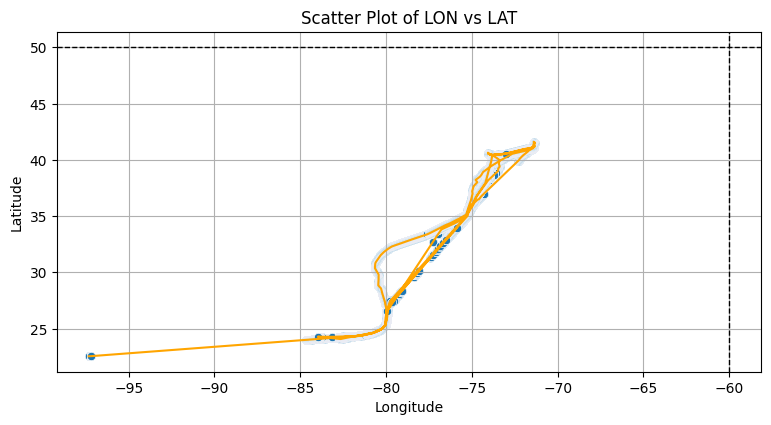

In [4]:
# Create the figure and subplot
plt.figure(figsize=(20, 15))
plt.subplot(3, 2, 3)

# Plot the scatter points
sns.scatterplot(x='LON', y='LAT', data=data)
plt.title('Scatter Plot of LON vs LAT')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add lines connecting the points
plt.plot(data['LON'], data['LAT'], linestyle='-', color='orange')  # Draw straight lines between points

# Add Cartesian grid lines
plt.axhline(y=50, color='black', linestyle='--', linewidth=1)  # Horizontal line at y=0 (x-axis)
plt.axvline(x=-60, color='black', linestyle='--', linewidth=1)  # Vertical line at x=0 (y-axis)
plt.grid(True)  # Enable the grid

# Show the plot
plt.show()

In [5]:
# Buat sequence data
SEQ_LENGTH = 10

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length]
        label = data.iloc[i+seq_length]
        sequences.append((seq[['LAT', 'LON', 'SOG', 'COG']].values, label[['LAT', 'LON']].values))
    return sequences

sequences = create_sequences(data, SEQ_LENGTH)

In [6]:
# Splitting Data
X, y = zip(*sequences)
X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.float32)

# Split data into training and test sets (80-20 split)
split_index = int(0.8 * len(X))
X_train_full, X_test = X[:split_index], X[split_index:]
y_train_full, y_test = y[:split_index], y[split_index:]

In [7]:
# Fit scaler on training data only
scalers = {col: MinMaxScaler() for col in ['LAT', 'LON', 'SOG', 'COG']}
for idx, col in enumerate(['LAT', 'LON', 'SOG', 'COG']):
    # Fit scaler only on training data
    scalers[col].fit(X_train_full[:, :, idx].reshape(-1, 1))
    
    # Transform training data
    X_train_full[:, :, idx] = scalers[col].transform(X_train_full[:, :, idx].reshape(-1, 1)).reshape(X_train_full[:, :, idx].shape)
    
    # Transform test data using the same scaler
    X_test[:, :, idx] = scalers[col].transform(X_test[:, :, idx].reshape(-1, 1)).reshape(X_test[:, :, idx].shape)

In [11]:
# Validate Results
print("Train data scaled:", X_train_full.min(), X_train_full.max())  # Expected: 0, 1
print("Test data scaled:", X_test.min(), X_test.max())              # Expected: May go slightly beyond [0, 1]

Train data scaled: 0.0 1.0
Test data scaled: 0.0 1.0192552


In [9]:
# Normalisasi kolom LAT dan LON
data['LAT_normalized'] = scalers['LAT'].transform(data['LAT'].values.reshape(-1, 1)).reshape(-1)
data['LON_normalized'] = scalers['LON'].transform(data['LON'].values.reshape(-1, 1)).reshape(-1)

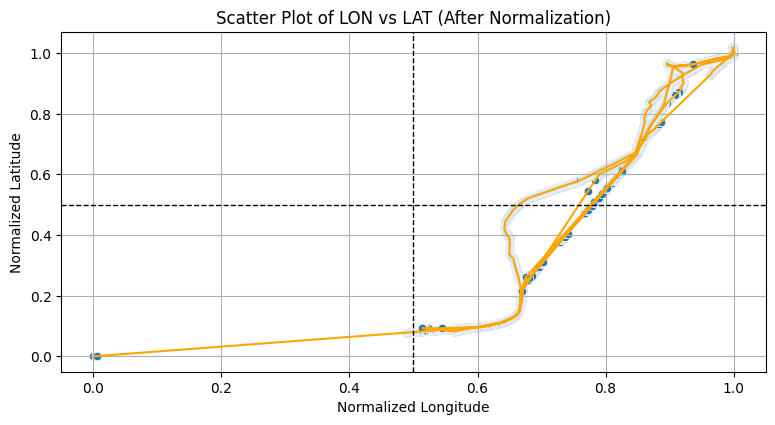

In [10]:
# Scatter plot setelah normalisasi

# Buat figure dan subplot baru
plt.figure(figsize=(20, 15))
plt.subplot(3, 2, 4)  # Menaruh plot di posisi yang berbeda

# Plot scatter points setelah normalisasi
sns.scatterplot(x='LON_normalized', y='LAT_normalized', data=data)
plt.title('Scatter Plot of LON vs LAT (After Normalization)')
plt.xlabel('Normalized Longitude')
plt.ylabel('Normalized Latitude')

# Tambahkan garis yang menghubungkan titik-titik
plt.plot(data['LON_normalized'], data['LAT_normalized'], linestyle='-', color='orange')

# Tambahkan garis kartesius sebagai referensi
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1)  # Menyesuaikan dengan skala normalisasi
plt.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
plt.grid(True)

# Tampilkan plot
plt.show()

In [12]:
def squeeze_excite_block(input, ratio=16):
    init = input
    filters = init.shape[-1]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = multiply([init, se])
    return x


def build_model(seq_length, embedding_dim):
    input_seq = Input(shape=(seq_length, 4), name='input_seq')

    # CNN layers
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_seq)
    x = squeeze_excite_block(x)
    x = GlobalAveragePooling1D()(x)

    # LSTM layers
    lstm_out = LSTM(64)(Lambda(lambda x: tf.expand_dims(x, axis=1))(x))  # Wrap tf.expand_dims

    # Fully connected layers
    output = Dense(2)(lstm_out)

    model = Model(inputs=input_seq, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model


In [13]:
# Fungsi untuk menghitung ARMSE, AMAPE, AED, dan AGD
def calculate_metrics(y_true, y_pred):
    # ARMSE (Average Root Mean Squared Error)
    armse_lat = np.sqrt(np.mean((y_true[:, 0] - y_pred[:, 0])**2))
    armse_lon = np.sqrt(np.mean((y_true[:, 1] - y_pred[:, 1])**2))
    armse = (armse_lat + armse_lon) / 2

    # AMAPE (Average Mean Absolute Percentage Error)
    amape_lat = np.mean(np.abs((y_true[:, 0] - y_pred[:, 0]) / y_true[:, 0])) * 100
    amape_lon = np.mean(np.abs((y_true[:, 1] - y_pred[:, 1]) / y_true[:, 1])) * 100
    amape = (amape_lat + amape_lon) / 2

    # AED (Average Euclidean Distance)
    aed = np.mean(np.sqrt((y_true[:, 0] - y_pred[:, 0])**2 + (y_true[:, 1] - y_pred[:, 1])**2))

    # AGD (Average Ground Distance) using Haversine formula
    agd = np.mean([haversine((y_true[i, 0], y_true[i, 1]), (y_pred[i, 0], y_pred[i, 1])) for i in range(len(y_true))])

    return {"ARMSE": armse, "AMAPE": amape, "AED": aed, "AGD": agd}

In [14]:
# Initialize Time Series Split Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

In [15]:
# Store metrics for each fold
fold_metrics = []
for fold_no, (train_index, val_index) in enumerate(tscv.split(X_train_full), start=1):
    print(f"Training fold {fold_no}...")

    # Split data into training and validation for this fold
    X_train, X_val = X_train_full[train_index], X_train_full[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    # Build the model
    model = build_model(SEQ_LENGTH, 4)

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Train the model
    history = model.fit(
        X_train, y_train, epochs=10, batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    # Predict on validation set
    y_val_pred = model.predict(X_val)

    # Verifikasi sebelum inverse transformasi
    print("Prediksi Latitude (sebelum inverse transformasi):", y_val_pred[:, 0])
    print("Prediksi Longitude (sebelum inverse transformasi):", y_val_pred[:, 1])

    # Inverse transform predictions and actual values
    y_val_actual = np.zeros_like(y_val)
    y_val_pred_actual = np.zeros_like(y_val_pred)

    y_val_actual[:, 0] = scalers['LAT'].inverse_transform(y_val[:, 0].reshape(-1, 1)).reshape(-1)
    y_val_actual[:, 1] = scalers['LON'].inverse_transform(y_val[:, 1].reshape(-1, 1)).reshape(-1)
    y_val_pred_actual[:, 0] = scalers['LAT'].inverse_transform(y_val_pred[:, 0].reshape(-1, 1)).reshape(-1)
    y_val_pred_actual[:, 1] = scalers['LON'].inverse_transform(y_val_pred[:, 1].reshape(-1, 1)).reshape(-1)

    print("Actual Latitude (setelah inverse transformasi):", y_val_actual[:, 0])
    print("Actual Longitude (setelah inverse transformasi):", y_val_actual[:, 1])
    print("Predicted Latitude (setelah inverse transformasi):", y_val_pred_actual[:, 0])
    print("Predicted Longitude (setelah inverse transformasi):", y_val_pred_actual[:, 1])

    # Calculate metrics for this fold
    metrics = calculate_metrics(y_val_actual, y_val_pred_actual)
    print(f"Fold {fold_no} Metrics: {metrics}")

    # Store metrics for this fold
    fold_metrics.append(metrics)

# Average metrics across all folds
average_metrics = {
    key: np.mean([fold[key] for fold in fold_metrics]) for key in fold_metrics[0]
}
print("\nAverage Metrics Across Folds:", average_metrics)


Training fold 1...

749/749 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step
Prediksi Latitude (sebelum inverse transformasi): [27.047928 27.047928 27.047928 ... 27.047928 27.047928 27.047928]
Prediksi Longitude (sebelum inverse transformasi): [-77.17325 -77.17325 -77.17325 ... -77.17325 -77.17325 -77.17325]
Actual Latitude (setelah inverse transformasi): [666.2083  666.2083  666.2083  ... 788.36053 788.36053 788.36053]
Actual Longitude (setelah inverse transformasi): [-2061.047  -2061.047  -2061.047  ... -1966.5634 -1966.5634 -1966.5634]
Predicted Latitude (setelah inverse transformasi): [528.3582 528.3582 528.3582 ... 528.3582 528.3582 528.3582]
Predicted Longitude (setelah inverse transformasi): [-2101.6057 -2101.6057 -2101.6057 ... -2101.6057 -2101.6057 -2101.6057]


ValueError: Latitude 666.2083129882812 is out of range [-90, 90]

In [16]:
# Setelah cross-validation selesai, latih model pada seluruh data pelatihan
model = build_model(SEQ_LENGTH, 4)
model.fit(X_train_full, y_train_full, epochs=10, batch_size=32)

# Evaluasi model pada test set
y_test_pred = model.predict(X_test)

# Inverse transform prediksi dan nilai aktual untuk test set
y_test_actual = np.zeros_like(y_test)
y_test_pred_actual = np.zeros_like(y_test_pred)

y_test_actual[:, 0] = scalers['LAT'].inverse_transform(y_test[:, 0].reshape(-1, 1)).reshape(-1)
y_test_actual[:, 1] = scalers['LON'].inverse_transform(y_test[:, 1].reshape(-1, 1)).reshape(-1)
y_test_pred_actual[:, 0] = scalers['LAT'].inverse_transform(y_test_pred[:, 0].reshape(-1, 1)).reshape(-1)
y_test_pred_actual[:, 1] = scalers['LON'].inverse_transform(y_test_pred[:, 1].reshape(-1, 1)).reshape(-1)

# Calculate metrics for the test set
test_metrics = calculate_metrics(y_test_actual, y_test_pred_actual)
print("Test Set Metrics:", test_metrics)

Epoch 1/10
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 877.0610 - mae: 21.1041
Epoch 2/10
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 24.6754 - mae: 4.2483
Epoch 3/10
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 24.5580 - mae: 4.2333
Epoch 4/10
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 24.5819 - mae: 4.2349
Epoch 5/10
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 24.5385 - mae: 4.2321
Epoch 6/10
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 24.6193 - mae: 4.2426
Epoch 7/10
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 24.5473 - mae: 4.2298
Epoch 8/10
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 24.6389 - mae: 4.2440
Epoch 9/10
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 24.7349 - mae: 4.2556
Epoch 10/10
4491/4491 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 24.6861 - mae: 4.2481
1123/1123 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step


ValueError: Latitude 758.5162353515625 is out of range [-90, 90]

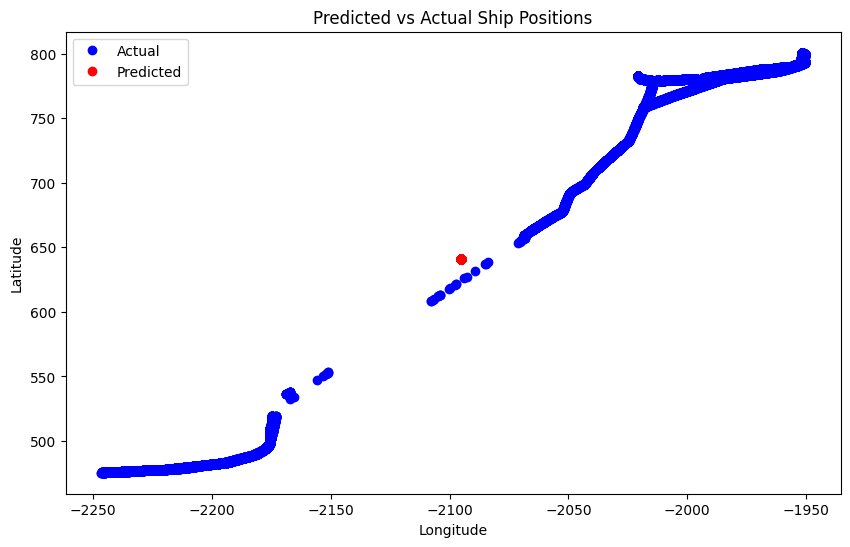

In [17]:
# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual[:, 1], y_test_actual[:, 0], 'bo', label='Actual')   # Longitude di sumbu x, Latitude di sumbu y
plt.plot(y_test_pred_actual[:, 1], y_test_pred_actual[:, 0], 'ro', label='Predicted')  # Prediksi Longitude di sumbu x, Latitude di sumbu y
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Predicted vs Actual Ship Positions')
plt.show()


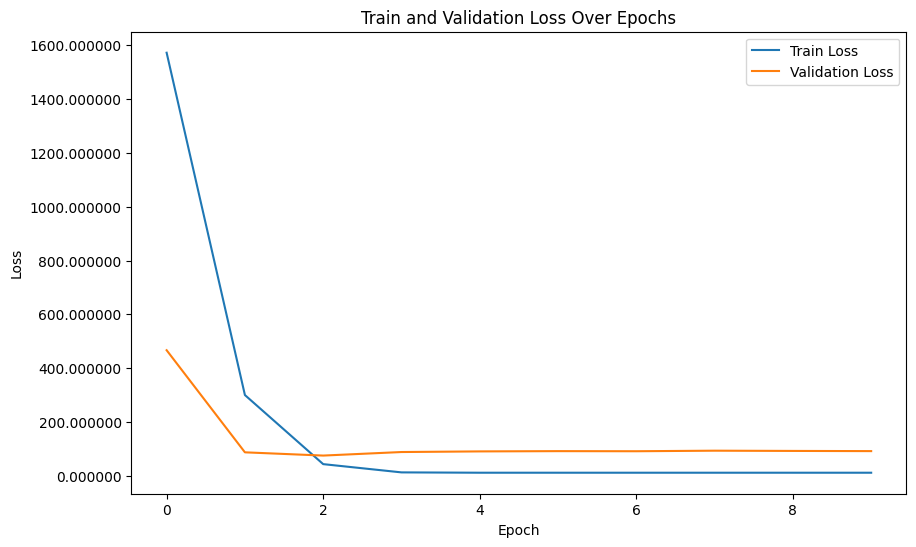

In [18]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))  # Show more decimal places
plt.show()


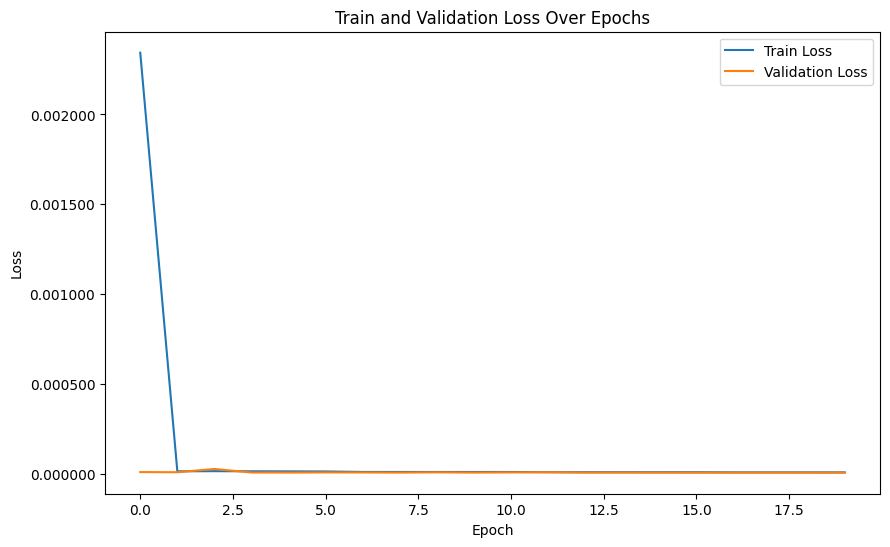

In [23]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))  # Show more decimal places
plt.show()


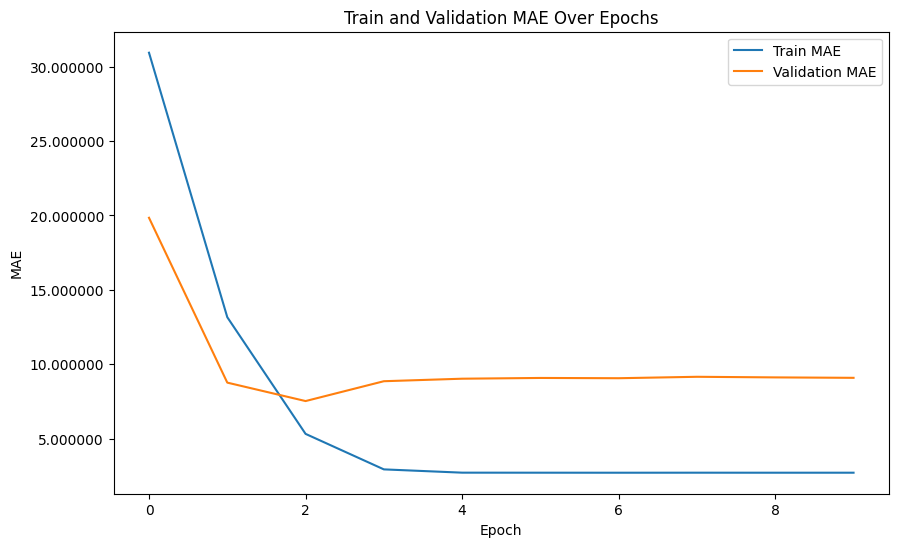

In [20]:
# Plot training & validation MAE values
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Train and Validation MAE Over Epochs')
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.6f'))  # Show more decimal places
plt.show()

In [21]:
def predict_next_position(lat_manual, lon_manual, sog_manual, cog_manual, model, scalers, seq_length=10):
    """
    Memprediksi latitude dan longitude berikutnya berdasarkan input manual dan model yang dilatih.

    Args:
    lat_manual: Latitude yang diinput secara manual.
    lon_manual: Longitude yang diinput secara manual.
    sog_manual: Speed Over Ground (SOG) yang diinput secara manual.
    cog_manual: Course Over Ground (COG) yang diinput secara manual.
    model: Model CNN-LSTM yang sudah dilatih.
    scalers: Dictionary yang berisi scaler untuk setiap fitur (LAT, LON, SOG, COG).
    seq_length: Panjang sequence yang dibutuhkan model, default 10.

    Returns:
    Prediksi latitude dan longitude berikutnya.
    """
    # Buat input array berdasarkan input manual
    input_data = np.array([[lat_manual, lon_manual, sog_manual, cog_manual]])

    # Lakukan scaling sesuai skema sebelumnya
    input_data[:, 0] = scalers['LAT'].transform(input_data[:, 0].reshape(-1, 1)).reshape(-1)
    input_data[:, 1] = scalers['LON'].transform(input_data[:, 1].reshape(-1, 1)).reshape(-1)
    input_data[:, 2] = scalers['SOG'].transform(input_data[:, 2].reshape(-1, 1)).reshape(-1)
    input_data[:, 3] = scalers['COG'].transform(input_data[:, 3].reshape(-1, 1)).reshape(-1)

    # Buat sequence dengan panjang seq_length dengan menduplikasi input manual
    sequence_input = np.tile(input_data, (seq_length, 1))

    # Sesuaikan input dengan panjang sequence yang dibutuhkan model
    sequence_input = np.expand_dims(sequence_input, axis=0).astype(np.float32)

    # Lakukan prediksi
    predicted = model.predict(sequence_input)

    # Lakukan inverse scaling agar prediksi kembali ke skala asli
    predicted[:, 0] = scalers['LAT'].inverse_transform(predicted[:, 0].reshape(-1, 1)).reshape(-1)
    predicted[:, 1] = scalers['LON'].inverse_transform(predicted[:, 1].reshape(-1, 1)).reshape(-1)

    return predicted[0, 0], predicted[0, 1]

# Contoh penggunaan
lat_manual = 24.05323
lon_manual = -84.21892
sog_manual = 22.3
cog_manual = 82.8

predicted_lat, predicted_lon = predict_next_position(lat_manual, lon_manual, sog_manual, cog_manual, model, scalers)

print(f"Prediksi Latitude berikutnya: {predicted_lat}")
print(f"Prediksi Longitude berikutnya: {predicted_lon}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediksi Latitude berikutnya: 641.2960205078125
Prediksi Longitude berikutnya: -2095.396484375
